# **Maliciously infering the possible path of a vehicle**

In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np

import utils

from tqdm.notebook import trange

import json

import matplotlib.pyplot as plt

In [10]:
MEAS_ROOT = "../dockeroutput/"

## **Preparing oracle knowledge**

In [3]:
#reading capacity data:
MOST_PATH = "../build_inputs//MoSTScenario/scenario/most.sumocfg"
PARKING_AREA_DEFINITIONS = "../build_inputs/MoSTScenario/scenario/in/add/most.parking.add.xml"

parking_df = pd.read_xml(PARKING_AREA_DEFINITIONS)
parking_df = parking_df[parking_df["roadsideCapacity"]>0]
parking_df = parking_df.set_index(["id"])

In [5]:
def collect_data(min_day, max_day):
    collected_data = None
    for day in trange(min_day, max_day):
        meas_path = MEAS_ROOT + "day_%d/"%day
        df_ = pd.read_csv(meas_path+"occupancies.csv")
        perc_ = []
        for i,r in df_.iterrows():
            perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
        df_["percentage"] = perc_
        if collected_data is None:
            collected_data = df_
        else:
            collected_data = pd.concat([collected_data, df_])
    return collected_data

In [31]:
oracle = collect_data(0, 60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [32]:
oracle.to_csv("../02_data/oracle.csv", index=False)

## **Checking a model**

In [2]:
oracle = pd.read_csv("../02_data/oracle.csv")

In [3]:
VEHICLE_ID = "commercial_3-1_98"

In [4]:
with open("../dockeroutput/day_0/vehicle_maps.json", "r") as f:
    maps = json.load(f)
    nominal_veh_to_id_encoding = maps["vehicle_to_idx_map"]
    nominal_id_to_veh_encoding = maps["idx_to_vehicle_map"]

In [5]:
veh_idx = nominal_veh_to_id_encoding[VEHICLE_ID]

In [6]:
model = keras.models.load_model("../04_nn_models/ind_%s"%VEHICLE_ID)

2023-01-29 08:21:48.817813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 08:21:48.869827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 08:21:48.870046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 08:21:48.871178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
PARKING_ID_LIST = [i for i in range(1059, 1186+1)]
MIN_T = 18220
MAX_T = 46800
MEAN = 0.59
STD = 0.35302

test_t = np.arange(14460, 50400+1, 60)
test_t = utils.normalize(test_t, MIN_T, MAX_T)

In [71]:
parking_losses = []
plist=[i for i in range(1059,1186+1)]
plist.remove(1148)

for parking in plist:
    id_encoding = utils.one_hot_encoder([parking]*len(test_t), PARKING_ID_LIST)
    test_d = np.hstack([id_encoding, test_t.reshape(len(test_t), 1)])
    occup = model.predict(test_d, batch_size=1000, verbose=0).reshape(len(test_t))
    oracle_occup = utils.standardize(oracle[oracle["ids"] == parking].groupby("timestamp")["percentage"].mean(),
                                     MEAN, STD)
    loss = np.mean((occup-oracle_occup)**2)
    parking_losses.append(loss)

In [72]:
nominal_vehicle_data = pd.read_csv(MEAS_ROOT+"day_0/vehicle_measurement.csv")
known_p_lots = nominal_vehicle_data[nominal_vehicle_data["veh_id"] == VEHICLE_ID]["parking_id"].unique()

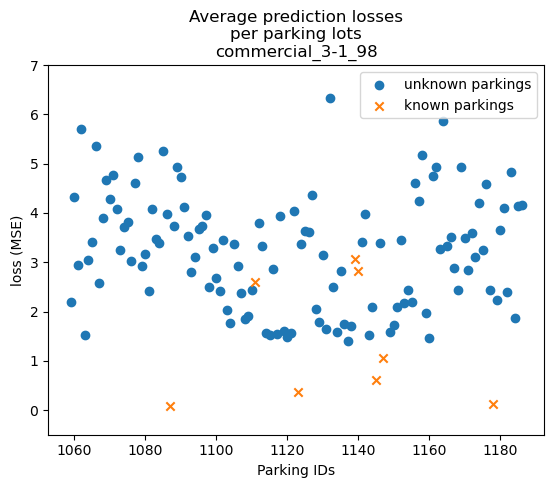

In [130]:
colors = []
unknown_x, unknown_y = [], []
known_x, known_y = [], []

for i, parking in enumerate(plist):
    if parking in known_p_lots:
        known_x.append(parking)
        known_y.append(parking_losses[i])
    else:
        unknown_x.append(parking)
        unknown_y.append(parking_losses[i])
        
plt.scatter(unknown_x, unknown_y, marker="o", label="unknown parkings")
plt.scatter(known_x, known_y, marker="x", label="known parkings")
plt.legend()
plt.xlabel("Parking IDs")
plt.ylabel("loss (MSE)")
plt.title("Average prediction losses\nper parking lots\n%s"%VEHICLE_ID)
plt.ylim(-0.5, 7)
plt.savefig("../05_doc/img/ploss_%s.png"%VEHICLE_ID)

### Checking average number of known parking lots:

In [60]:
with open("../02_data/known_parkings.json", "r") as f:
    known_parkings_by_vehicles = json.load(f)
with open("../02_data/known_moving_times.json", "r") as f:
    known_moving_times = json.load(f)

In [62]:
num_known = []
for i in known_parkings_by_vehicles:
    num_known.append(len(known_parkings_by_vehicles[i]))
print("Average number of known parking lots:\t%.2f"%np.mean(num_known))

Average number of known parking lots:	5.22


> The best 5 parking lots will be candidates for visited parking lots.

## **Inference**

In [63]:
NUM_BEST = 5

In [77]:
best_parkings = np.argsort(parking_losses)[:NUM_BEST]+min(plist)
for i in range(len(best_parkings)):
    if best_parkings[i] > 1148:
        best_parkings[i] += 1

In [78]:
best_parkings

array([1087, 1178, 1123, 1145, 1147])

In [76]:
known_p_lots

array([1087, 1140, 1178, 1139, 1111, 1123, 1145, 1147])

In [111]:
parking_losses_time = []

for t in range(14460, 50400+1, 60):
    id_encoding = utils.one_hot_encoder(best_parkings, PARKING_ID_LIST)
    time = np.array([utils.normalize(t, MIN_T, MAX_T)]*len(id_encoding))
    test_d = np.hstack([id_encoding, time.reshape(len(id_encoding), 1)])
    occup = model.predict(test_d, batch_size=1000, verbose=0).reshape(len(best_parkings))
    oracle_occup = []
    for bp in best_parkings:
        oracle_f = oracle[oracle["ids"] == bp]
        oracle_occup.append(utils.standardize(oracle_f[oracle_f["timestamp"] == t].groupby("ids")["percentage"].mean(),
                                         MEAN, STD))
    #loss = np.sum( ((occup-oracle_occup)**2) < 0.01)
    oracle_occup = np.array(oracle_occup)
    loss = np.mean((occup-oracle_occup)**2)
    #loss = np.std(occup)
    parking_losses_time.append(loss)

In [126]:
#removing "random peaks" by moving average of 60 minutes:
WINDOW = 60
parking_losses_cv = np.convolve(parking_losses_time, np.ones(WINDOW))/WINDOW
parking_losses_cv = parking_losses_cv[WINDOW:]
parking_losses_cv = parking_losses_cv[:-WINDOW]

In [142]:
len(parking_losses_cv)+120

659

In [139]:
np.argmin(parking_losses_cv)/60

5.416666666666667

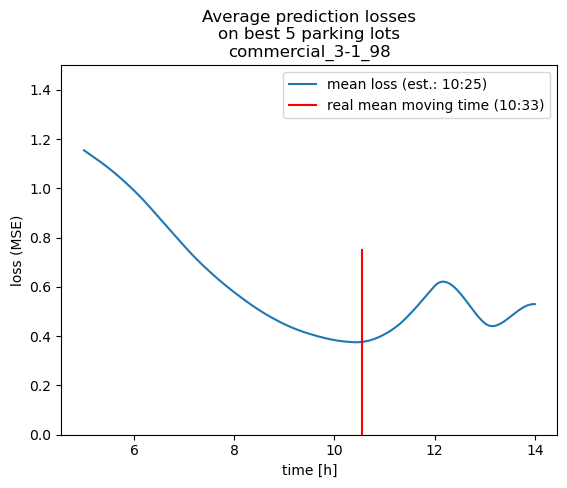

In [149]:
predt = np.argmin(parking_losses_cv)+4*60+WINDOW
pred_h = predt // 60
pred_m = predt % 60

realt = int(known_moving_times[VEHICLE_ID]/60)
real_h = realt // 60
real_m = realt % 60

plt.plot(np.linspace(4+WINDOW/60, 15-WINDOW/60, len(parking_losses_cv)), parking_losses_cv,
         label="mean loss (est.: %d:%d)"%(pred_h, pred_m))
plt.axvline(x=realt/60, ymin=0, ymax=0.5,
           c="r", label="real mean moving time (%d:%d)"%(real_h, real_m))
plt.xlabel("time [h]")
plt.ylabel("loss (MSE)")
plt.ylim(0, 1.5)
plt.title("Average prediction losses\non best 5 parking lots\n%s"%VEHICLE_ID)
plt.legend()
plt.savefig("../05_doc/img/tloss_%s.png"%VEHICLE_ID)
#plt.plot(parking_losses_time)
#print((np.argmin(parking_losses_time)*60+14400)/3600)
#plt.plot(np.convolve(parking_losses_time, np.ones(90))/90, alpha=0.4, label="error")
#plt.plot(np.diff(parking_losses_time), alpha=0.4, label="error")